In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
data = np.genfromtxt('gradientProfile2.txt')

In [11]:
df = pd.DataFrame(data)
df.columns = ['x', 'y', 'z', 'B']
df = df.drop('x', axis=1)
df.head()

,y,z,B
0,-0.124583,-0.124583,0.000055
1,-0.123750,-0.124583,0.000055
2,-0.122917,-0.124583,0.000055
3,-0.122083,-0.124583,0.000055
4,-0.121250,-0.124583,0.000055


In [12]:
Ubz = 0.07 /4+0.01
Lbz = -0.07/4+0.01
Uby = 0.07 /4+0.02
Lby = -0.07/4+0.02
df = df.sort_values(by=['y','z'])
#Upper and lower values of y-window, must be FOV of MRI
df = df[df.y <= Uby]
df = df[df.y >= Lby]
#Upper and lower values of z-window, must be FOV of MRI
df = df[df.z <= Ubz]
df = df[df.z >= Lbz]
print(df)

              y         z         B
42453  0.002917 -0.007083  0.013664
42753  0.002917 -0.006250  0.013664
43053  0.002917 -0.005417  0.023679
43353  0.002917 -0.004583  0.023679
43653  0.002917 -0.003750  0.040175
...         ...       ...       ...
53594  0.037083  0.023750 -0.000594
53894  0.037083  0.024583 -0.000614
54194  0.037083  0.025417 -0.000435
54494  0.037083  0.026250 -0.000435
54794  0.037083  0.027083 -0.000267

[1764 rows x 3 columns]


In [13]:
data = df.to_numpy()
print(np.sqrt(data.size/3))
#print(data)

42.0


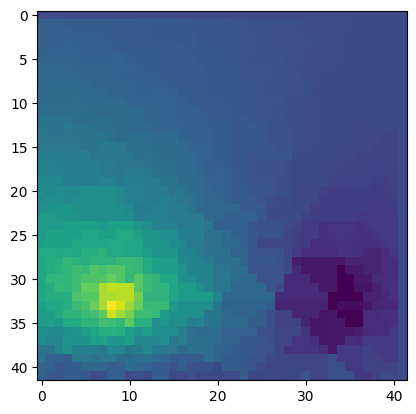

In [14]:
#Convert numpy array to image matrix
sz = np.sqrt(data.size/3)
sz = sz.astype(np.int64)
dataArray = np.zeros((sz,sz))
for ii in range(0, sz-1):
    for jj in range(0, sz-1):
        dataArray[sz-1-jj,ii] = data[ii * sz + jj,2]

fig, ax = plt.subplots()
im = ax.imshow(dataArray)
plt.show()


In [15]:
Porder = 20
A = np.ones((data.shape[0], 1))  # Initialize the matrix with a column of ones
# Construct polynomial features up to Porder
for p in range(1, Porder):
    A = np.concatenate((A, np.power(data[:, 0], p).reshape(-1, 1), np.power(data[:, 1], p).reshape(-1, 1)), axis=1)

b = data[:,2]

# Perform LU decomposition
def lu_decomposition(A):
    n = len(A)
    L = np.zeros((n, n))
    U = np.zeros((n, n))

    for i in range(n):
        L[i, i] = 1

    for k in range(n):
        U[k, k:] = A[k, k:] - np.dot(L[k, :k], U[:k, k:])
        L[(k+1):, k] = (A[(k+1):, k] - np.dot(L[(k+1):, :], U[:, k])) / U[k, k]

    return L, U

# Call the function to get L and U matrices
L, U = lu_decomposition(A.T @ A)

# Solve for y in Ly = b (forward substitution)
def forward_substitution(L, b):
    n = len(b)
    y = np.zeros(n)

    for i in range(n):
        y[i] = b[i] - np.dot(L[i, :i], y[:i])

    return y

y = forward_substitution(L, A.T @ b)

# Solve for x in Ux = y (back substitution)
def back_substitution(U, y):
    n = len(y)
    x = np.zeros(n)

    for i in range(n - 1, -1, -1):
        x[i] = (y[i] - np.dot(U[i, (i+1):], x[(i+1):])) / U[i, i]

    return x

sol = back_substitution(U, y)

print(sol)

[-2.52234639e-01  3.06955434e+02  1.07686466e+00 -1.25888488e+05
 -1.28538618e+03  2.70868889e+07  5.30073553e+04 -3.32632964e+09
  5.14741010e+07  2.33129828e+11 -5.10166978e+09 -8.05086846e+12
 -8.95165918e+11  1.32750170e+13  1.54805706e+14  7.18406476e+15
 -4.50533196e+14 -4.18154745e+16 -1.32379831e+18 -8.92029730e+18
  1.01600161e+20  1.87484208e+20 -2.54152319e+21  2.62523121e+20
  6.00569257e+21  1.17894016e+23 -1.57793165e+24 -5.25865193e+24
  8.29860240e+25 -4.78231730e+25  5.29237245e+27  3.93468707e+27
 -4.17587028e+29 -1.66175928e+28  9.30708970e+30 -9.93048093e+29
 -5.58565569e+31  1.07201696e+31 -3.21268623e+32]


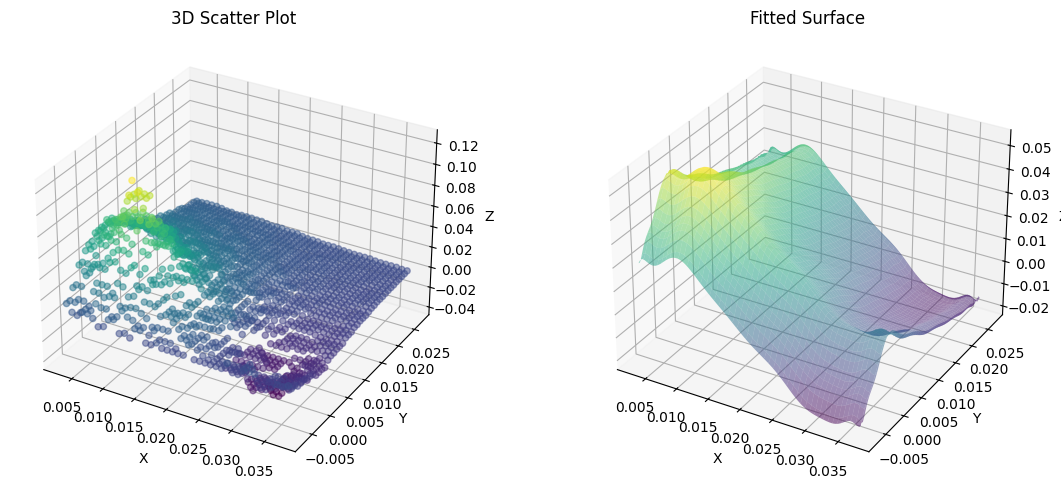

In [16]:
# Assuming 'sol' contains the coefficients obtained from regression
def reconstructed_function(x, y, c):
    z = c[0]
    for p in range(1,Porder): 
        z = z + c[2*p-1]*x**(p) + c[2*p]*y**(p) 
    #z = c[0] + c[1]*x**1 + c[2]*y**1 + c[3]*x**2 + c[4]*y**2 + c[5]*x**3 + c[6]*y**3 + c[7]*x**4 + c[8]*y**4 + c[9]*x**5 + c[10]*y**5
    return z

# Generating points for plotting the surface
x_vals = np.linspace(min(data[:, 0]), max(data[:, 0]), 100)
y_vals = np.linspace(min(data[:, 1]), max(data[:, 1]), 100)
x_mesh, y_mesh = np.meshgrid(x_vals, y_vals)
z = reconstructed_function(x_mesh, y_mesh, sol)

# Plotting both figures side by side
fig = plt.figure(figsize=(12, 5))

# 3D Scatter plot for the data
ax = fig.add_subplot(121, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=data[:, 2], cmap='viridis', alpha=0.5)
ax.set_title('3D Scatter Plot')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Fitted surface plot
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x_mesh, y_mesh, z, alpha=0.5, cmap='viridis')
ax.set_title('Fitted Surface')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.tight_layout()
plt.show()

In [17]:
rSq = np.ones(Porder)
for ii in range(Porder):
    #print(ii)
    A = np.ones((data.shape[0], 1))  # Initialize the matrix with a column of ones

    # Construct polynomial features up to Porder
    for p in range(1, ii):
        A = np.concatenate((A, np.power(data[:, 0], p).reshape(-1, 1), np.power(data[:, 1], p).reshape(-1, 1)), axis=1)

    b = data[:,2]
    # Call the function to get L and U matrices
    L, U = lu_decomposition(A.T @ A)
    y = forward_substitution(L, A.T @ b)
    sol = back_substitution(U, y)
    
    A = np.ones((data.shape[0], 1))
    for p in range(1, ii):
        A = np.concatenate((A, np.power(data[:, 0], p).reshape(-1, 1), np.power(data[:, 1], p).reshape(-1, 1)), axis=1)
    # Calculate the predicted values
    predicted_values = np.dot(A, sol)

    # Calculate R² score
    r_squared = r2_score(data[:, 2], predicted_values)
    rSq[ii] = r_squared
    #print("R-squared value:", r_squared)


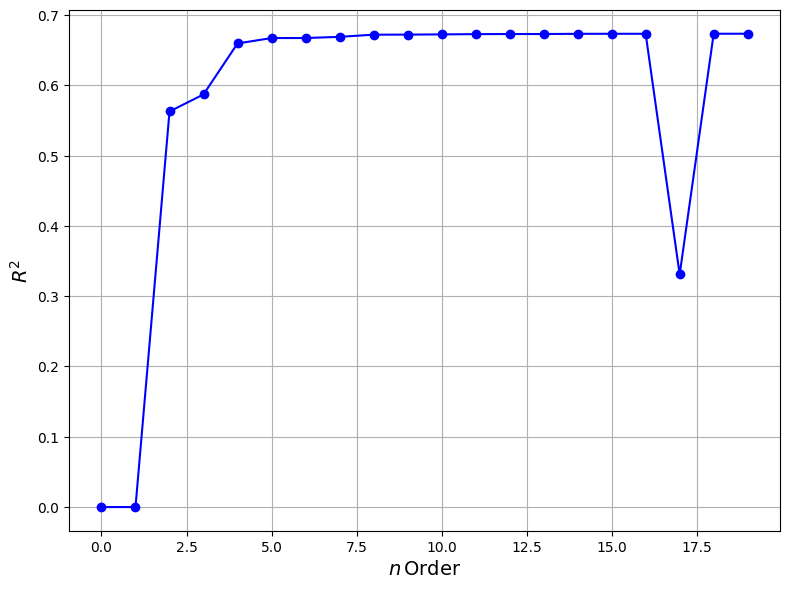

In [18]:
# Plotting
plt.figure(figsize=(8, 6))
plt.plot(range(Porder), rSq, marker='o', linestyle='-', color='blue')

# Set logarithmic scale for y-axis
#plt.yscale('log')

# Labeling the axes using LaTeX math code
plt.xlabel(r'$n \, \mathrm{Order}$', fontsize=14)
plt.ylabel(r'$R^2$', fontsize=14)

plt.grid(True)
plt.tight_layout()

plt.show()